In [80]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seawater as sw

# Simple Example

### Artificial density field (Cyclone)

In [309]:
# z0=-np.linspace(0,200,20)
z0=np.linspace(0,200,20)[::-1]

x=np.linspace(-120,120,50)

z_matrix=np.tile(z0,(x.shape[0],1)).T
x_matrix=np.tile(x,(z0.shape[0],1))

t_out=np.linspace(23.5,26.5,z0.shape[0])[::-1]
t_in=np.linspace(23.5,26.1,z0.shape[0])[::-1]

r0=100

T_out=np.tile(t_out,(x.shape[0],1))
T_in=np.tile(t_in,(x.shape[0],1))

T=(T_out + (T_in-T_out)*np.exp(-((x_matrix.T/r0)**2))).T
rho_est=sw.dens0(s=36,t=T)
g=9.8

In [310]:
rho=xr.DataArray(data=rho_est,
                 coords={'distance':(('x','z'),x_matrix),'depth':(('x','z'),z_matrix)},
                 dims=['x','z'])

rho_levels=np.linspace(rho.min(),rho.max(),15)

In [311]:
#plot specs

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

xdec=(x.max()*2)/5

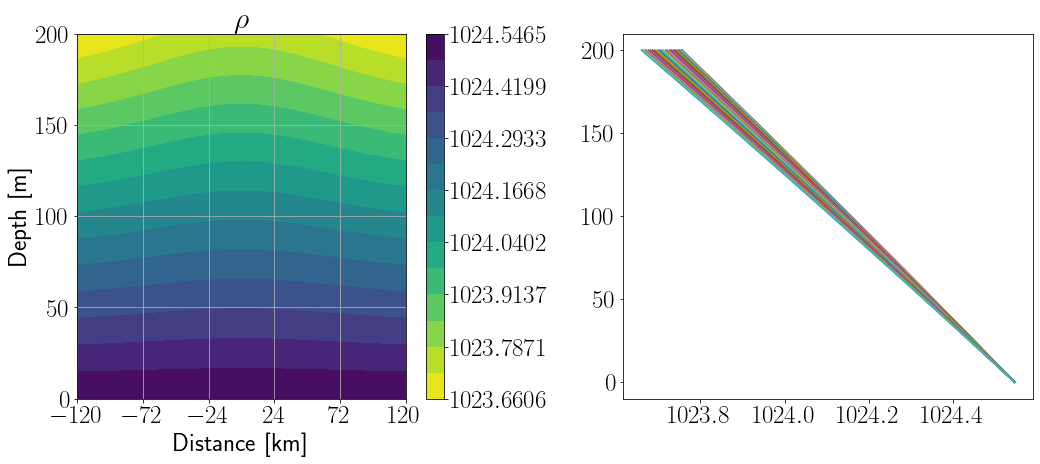

In [312]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.contourf(x,z0,rho,levels=rho_levels,cmap='viridis_r')
plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$\rho$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,2,2)
plt.plot(rho,z0)

plt.tight_layout()

### Sorting density

In [313]:
# "xarray method (not working)"
# rho_stacked=rho.stack(z_star=("x","z"))
# rho_sorted=rho_stacked.copy().sortby(rho_stacked.copy())
# rho_star=rho_sorted.unstack('z_star')

"numpy method (working but janky)"
rho_stacked=np.ravel(rho)
index_sorted=np.argsort(rho_stacked)

# rho_sorted=np.sort(rho_stacked)
# rho_star=rho_sorted.reshape(rho.shape)
rho_star=rho_stacked[index_sorted].reshape(rho.shape)


z_stacked=np.ravel(z_matrix)
z_star=z_stacked[index_sorted].reshape(rho.shape)

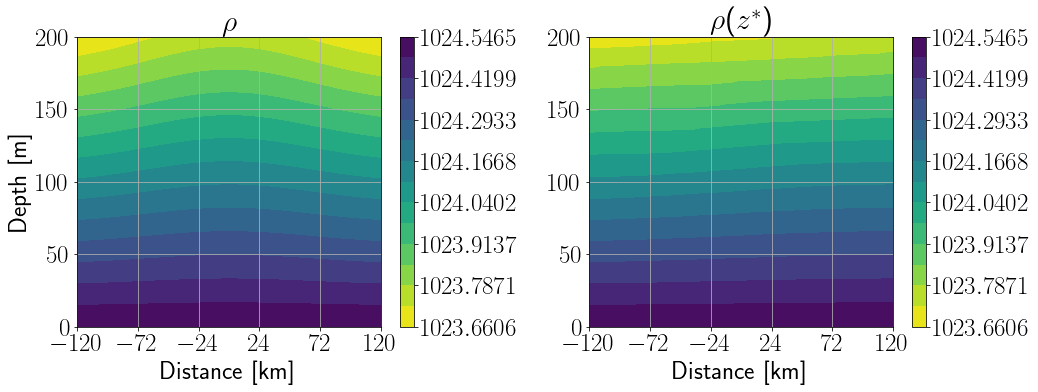

In [314]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.contourf(x,z0,rho,levels=rho_levels,cmap='viridis_r')
plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$\rho$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,2,2)
# rho_star.plot(x='distance',y='depth',cmap='viridis_r')
# plt.pcolormesh(rho['distance'],z0,rho_star,cmap='viridis_r')
plt.contourf(x,z0,rho_star,levels=rho_levels,cmap='viridis_r')

plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('')
plt.title(r'$\rho$($z^*$)')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.tight_layout()

 $\rho(z*)$ is (approximately) only a function of z

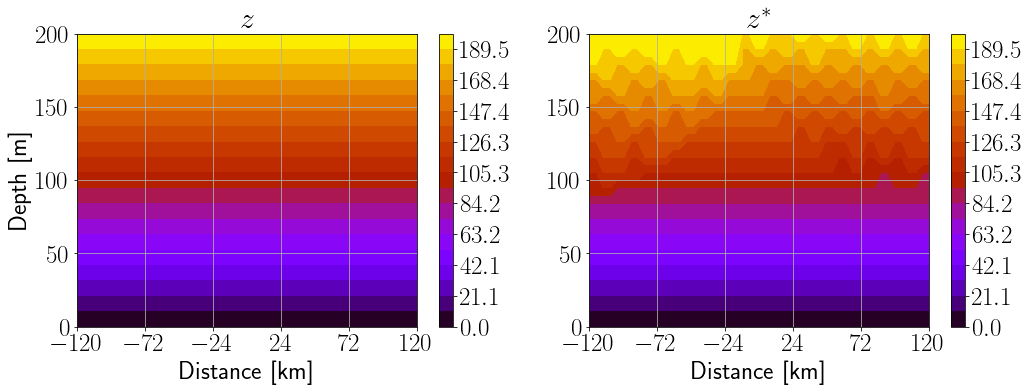

In [315]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,z_matrix,levels=z0[::-1],cmap='gnuplot')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$z$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()

plt.subplot(1,2,2)
# rho_star.plot(x='distance',y='depth',cmap='viridis_r')
# plt.pcolormesh(x,z0,z_star,cmap='jet_r')
plt.contourf(x,z0,z_star,levels=z0[::-1],cmap='gnuplot')

plt.colorbar()
plt.xlabel('Distance [km]')
plt.ylabel('')
plt.title(r'$z^*$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.grid()


plt.tight_layout()

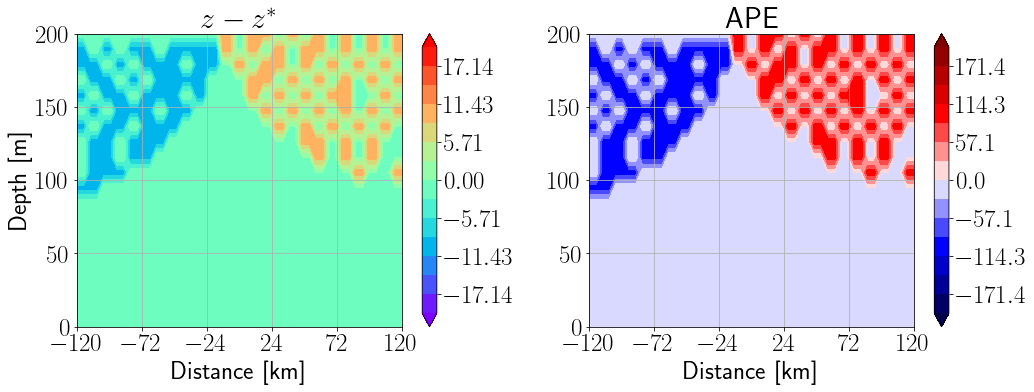

In [316]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,z_matrix-z_star,levels=np.linspace(-20,20,15),extend='both',cmap='rainbow')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'$z-z^*$')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.subplot(1,2,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
plt.contourf(x,z0,(9.8)*rho*(z_matrix-z_star)/1e3,extend='both',levels=np.linspace(-200,200,15),cmap='seismic')
plt.colorbar()

plt.xlabel('Distance [km]')
# plt.ylabel('Depth [m]')
plt.title(r'APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()

plt.tight_layout()

In [318]:
PE=g*rho*z_matrix
BPE=g*rho*(z_star)
APE=g*rho*(z_matrix-z_star)


/var/folders/2f/39w3v_8x31g2pn55zd5dfwdr0000gn/T/ipykernel_26057/1222786036.py:6: UserWarning: The following kwargs were not used by contour: 'level'
  c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')
/var/folders/2f/39w3v_8x31g2pn55zd5dfwdr0000gn/T/ipykernel_26057/1222786036.py:19: UserWarning: The following kwargs were not used by contour: 'level'
  c2=plt.contourf(x,z0,BPE/scale,level=np.linspace(BPE.min()/scale,BPE.max()/scale,35),cmap='GnBu')


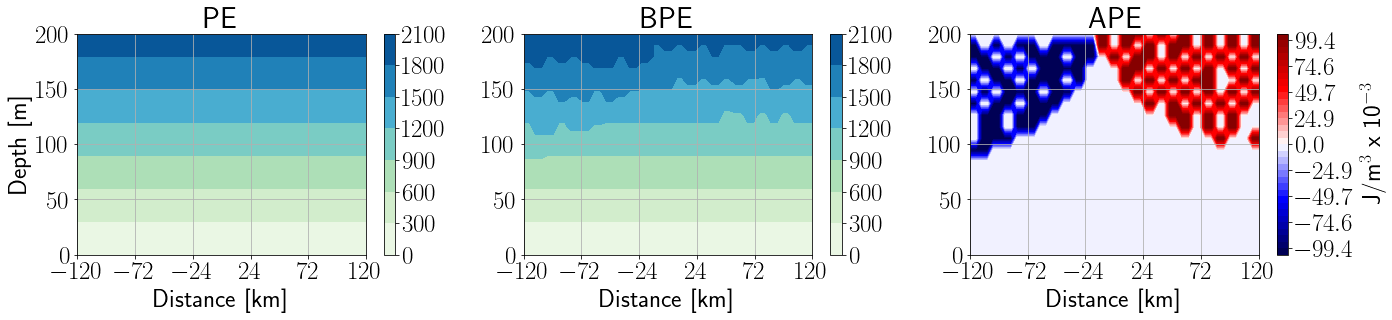

In [325]:
scale=1e3
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'PE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.colorbar()
plt.grid()


plt.subplot(1,3,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c2=plt.contourf(x,z0,BPE/scale,level=np.linspace(BPE.min()/scale,BPE.max()/scale,35),cmap='GnBu')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.title(r'BPE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.subplot(1,3,3)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c3=plt.contourf(x,z0,APE/scale,levels=np.linspace(-np.abs(APE).max()/scale,np.abs(APE).max()/scale,35),cmap='seismic')
plt.colorbar(c3,label=r'J/m$^3$ x 10$^{-3}$')

plt.xlabel('Distance [km]')
plt.title(r'APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()


plt.tight_layout()

/var/folders/2f/39w3v_8x31g2pn55zd5dfwdr0000gn/T/ipykernel_26057/1998924791.py:5: UserWarning: The following kwargs were not used by contour: 'level'
  c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')
/var/folders/2f/39w3v_8x31g2pn55zd5dfwdr0000gn/T/ipykernel_26057/1998924791.py:18: UserWarning: The following kwargs were not used by contour: 'level'
  c2=plt.contourf(x,z0,(BPE+APE)/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')


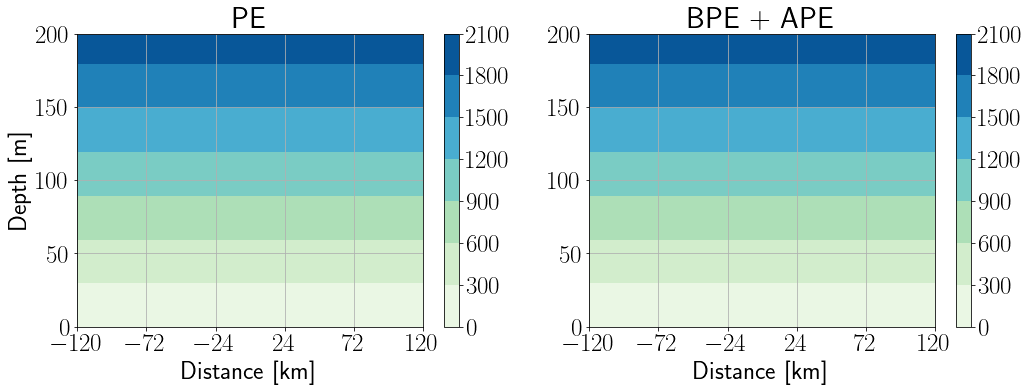

In [327]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c1=plt.contourf(x,z0,PE/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')

plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
plt.title(r'PE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())
plt.colorbar()
plt.grid()


plt.subplot(1,2,2)
# plt.pcolormesh(x,z0,z_matrix,cmap='jet_r')
c2=plt.contourf(x,z0,(BPE+APE)/scale,level=np.linspace(PE.min()/scale,PE.max()/scale,35),cmap='GnBu')
plt.colorbar()

plt.xlabel('Distance [km]')
plt.title(r'BPE + APE')
plt.xticks(np.arange(x.min(),x.max()+xdec,xdec))
plt.xlim(x.min(),x.max())

plt.grid()

plt.tight_layout()